# ToDo: 
+ 期待値がほぼ 0 になっている理由を探す。回避できるようなら回避
+ C = 3 * n_qubits の理由
+ ~~QPU のばらつき改善~~

In [1]:
%matplotlib inline
%pip freeze > requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import os
from heisenberg_graph import (
    HeisenbergModel,
    get_n_steps,
    get_graph,
    get_positions,
    get_initial_layout,
    get_prob0,
    extract_probs,
)
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
import mthree
import pickle
import networkx as nx
from datetime import datetime, timezone
import json

In [3]:
# Option1: Use IBM Quantum backend.
# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
service = QiskitRuntimeService()
# backend_qpu = service.least_busy(simulator=False, interactional=True)
backend_qpu = service.backend("ibm_marrakesh")

# Option2: Use local AerSimulator as the backend.
backend_sim = AerSimulator()

noise_model = NoiseModel.from_backend(backend_qpu)
backend_sim_noisy = AerSimulator(noise_model=noise_model)

print(f"Using backend QPU: {backend_qpu}")
print(f"Using backend simulator: {backend_sim}")
print(f"Using backend noisy simulator: {backend_sim_noisy}")

Using backend QPU: <IBMBackend('ibm_marrakesh')>
Using backend simulator: AerSimulator('aer_simulator')
Using backend noisy simulator: AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['measure', 'sx', 'reset', 'x', 'id', 'cz']>)


# データセット作成 $\exp(-\beta H)$

In [4]:
n_samples = 20
n_qubits = 4
beta = 1
rng = np.random.default_rng(42)

graph_type = "line"
# ghz_qubits = list(range(n_qubits // 2))
# ghz_qubits = list(range(0, n_qubits, 2))
# print(f"GHZ qubits: {ghz_qubits}")

## Create graph (Demo)

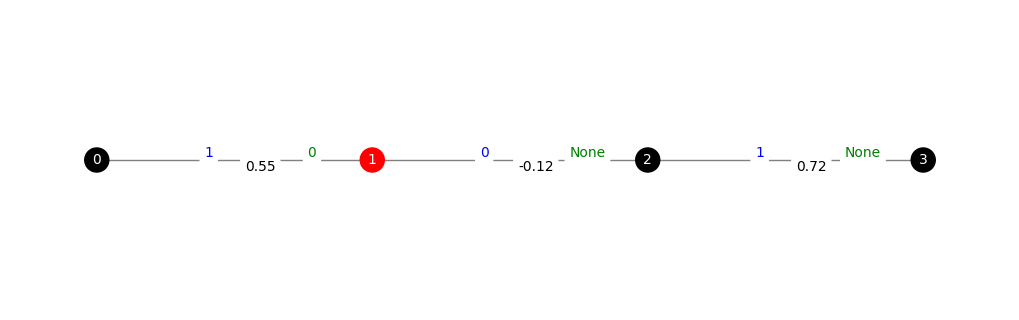

In [5]:
G = get_graph(n_qubits, rng, graph_type)

positions = get_positions(n_qubits, graph_type)

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
edge_interaction_order_labels = {
    edge: f"{G.edges[edge]['interaction_order']}" for edge in G.edges
}
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# グラフを描画
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'interaction_order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_interaction_order_labels,
    font_size=10,
    font_color="blue",
    label_pos=0.4,
    verticalalignment="bottom",
)

# エッジの 'cnot' 'order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

In [6]:
# State |111000> (half 1 and half 0 state) (can be adjusted for other sizes)
state = np.zeros(2**n_qubits, dtype=complex)
index = int("1" * (n_qubits // 2) + "0" * (n_qubits // 2), 2)
state[index] = 1
print("1" * (n_qubits // 2) + "0" * (n_qubits // 2))
print(f"index: {index}")

1100
index: 12


## Non Trotter simulation (directly compute the expectation value)

In [7]:
data = []
eigvals_list = []
graphs = []
matrix_norms = []  # For debugging

for i in range(n_samples):
    print(f"Sample {i}/{n_samples}")
    G = get_graph(n_qubits, rng, graph_type)
    Js = [G.edges[edge]["J"] for edge in G.edges]
    heisenberg = HeisenbergModel(n_qubits, G)

    # Shifted Hamiltonian
    H = heisenberg.H
    eigvals = heisenberg.eigvals
    eigvals_list.append(eigvals)
    matrix_norms.append(np.linalg.norm(H, ord=2))

    fH = scipy.linalg.expm(-beta * H)

    # Compute the expectation value <111000|exp(-beta*H)|111000>
    y = np.vdot(state, fH @ state).real
    data.append({"Js": Js, "expected_value": y})
    graphs.append(G)

df = pd.DataFrame(data)
df

Sample 0/20
Sample 1/20
Sample 2/20
Sample 3/20
Sample 4/20
Sample 5/20
Sample 6/20
Sample 7/20
Sample 8/20
Sample 9/20
Sample 10/20
Sample 11/20
Sample 12/20
Sample 13/20
Sample 14/20
Sample 15/20
Sample 16/20
Sample 17/20
Sample 18/20
Sample 19/20


,Js,expected_value
0,"[0.3947360581187278, -0.8116453042247009, 0.95...",0.019342
1,"[0.5222794039807059, 0.5721286105539076, -0.74...",0.240820
2,"[-0.09922812420886573, -0.25840395153483753, 0...",0.032718
3,"[0.2877302401613291, 0.64552322654166, -0.1131...",0.415421
4,"[-0.5455225564304462, 0.1091695740316696, -0.8...",0.903064
5,"[0.6552623439851641, 0.2633287982441297, 0.516...",0.017484
6,"[-0.2909480637402633, 0.9413960487898065, 0.78...",0.208174
7,"[0.5567669941475237, -0.6107225842960649, -0.0...",0.106176
8,"[-0.9123924684255424, -0.6914210158649043, 0.3...",0.162962
9,"[0.48952431181563427, 0.93501946486842, -0.348...",0.337633


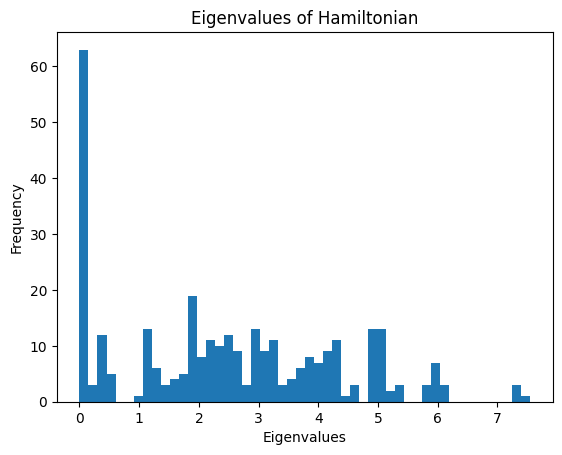

In [8]:
# Plot histogram of eigenvalues
eigvals_array = np.array(eigvals_list).flatten()
plt.hist(eigvals_array, bins=50)
plt.xlabel("Eigenvalues")
plt.ylabel("Frequency")
plt.title("Eigenvalues of Hamiltonian")
plt.show()

In [9]:
# Parameters for the Fourier feature generation
C = 6 * n_qubits  # upper bound for eigenvalues (WHY?)
# C = max(matrix_norms)  # upper bound for eigenvalues
print(f"C: {C}")
print(f"max matrix norm: {max(matrix_norms)}")  # For debugging
n_features = 5  # Number of Fourier features

times = [2 * np.pi * k / C for k in range(n_features)]
print(f"times: {times}")

C: 24
max matrix norm: 7.550249028442799
times: [0.0, 0.2617993877991494, 0.5235987755982988, 0.7853981633974483, 1.0471975511965976]


In [10]:
current_time = (
    datetime.now(timezone.utc).isoformat(timespec="minutes").replace("+00:00", "Z")
)

path = f"./data/{current_time}_{n_qubits}_{backend_qpu.name}_{graph_type}"
os.makedirs(path, exist_ok=True)
print(f"current_time: {current_time}")
print(f"Saving data to {path}")

current_time: 2024-11-25T05:57Z
Saving data to ./data/2024-11-25T05:57Z_4_ibm_marrakesh_line


In [11]:
# Save parameters
with open(
    f"./data/{current_time}_{n_qubits}_{backend_qpu.name}_{graph_type}/params.pkl", "wb"
) as f:
    pickle.dump(
        {
            "n_samples": n_samples,
            "n_qubits": n_qubits,
            "backend_qpu_name": backend_qpu.name,
            "beta": beta,
            "C": C,
            "n_features": n_features,
            "times": times,
            "Js": df["Js"].values,
            "graphs": graphs,
            "expected_values": df["expected_value"].values,
        },
        f,
    )

In [12]:
# Load parameters
with open(f"{path}/params.pkl", "rb") as f:
    params = pickle.load(f)

n_samples = params["n_samples"]
n_qubits = params["n_qubits"]
backend_qpu_name = params["backend_qpu_name"]
beta = params["beta"]
C = params["C"]
n_features = params["n_features"]
times = params["times"]
all_Js = params["Js"]
graphs = params["graphs"]
all_expected_values = params["expected_values"]

# Create Fourier feature

## Trotter simulation (Exact)

In [13]:
# Exact simulation
data = []
probs_phase0_exact = {}
probs_phase1_exact = {}
probs_phase2_exact = {}
probs_phase3_exact = {}

# Generate the dataset with Fourier features
for i in range(n_samples):
    print(f"Calculating features for sample {i}/{n_samples}")
    Js = all_Js[i]
    lambda_ref = np.sum(Js)  # Reference eigenvalue.
    heisenberg_exact = HeisenbergModel(n_qubits, graphs[i])
    features_exact = []

    probs_phase0_exact[f"sample{i}"] = {}
    probs_phase1_exact[f"sample{i}"] = {}
    probs_phase2_exact[f"sample{i}"] = {}
    probs_phase3_exact[f"sample{i}"] = {}

    # Compute the Fourier features for different times
    for k in range(n_features):
        prob_phase0 = heisenberg_exact.exact_simulation(times[k], phase=0)
        prob_phase1 = heisenberg_exact.exact_simulation(times[k], phase=1)
        prob_phase2 = heisenberg_exact.exact_simulation(times[k], phase=2)
        prob_phase3 = heisenberg_exact.exact_simulation(times[k], phase=3)

        probs_phase0_exact[f"sample{i}"][f"f_{k}"] = prob_phase0
        probs_phase1_exact[f"sample{i}"][f"f_{k}"] = prob_phase1
        probs_phase2_exact[f"sample{i}"][f"f_{k}"] = prob_phase2
        probs_phase3_exact[f"sample{i}"][f"f_{k}"] = prob_phase3

        inner_product = np.exp(-1j * lambda_ref * times[k]) * (
            (prob_phase0 - prob_phase1) + 1j * (prob_phase2 - prob_phase3)
        )
        features_exact.append(inner_product.real)
        if k != 0:
            features_exact.append(inner_product.imag)
    data.append([i, *features_exact, all_expected_values[i]])

# Create column names for the DataFrame
columns = []
columns.append("sample_id")
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")
columns.append("expected_value")

# Convert to a DataFrame
data_exact_df = pd.DataFrame(data, columns=columns)
display(data_exact_df)

# Save the exact data
data_exact_df.to_json(f"{path}/data_exact_df.json")

Calculating features for sample 0/20
Calculating features for sample 1/20
Calculating features for sample 2/20
Calculating features for sample 3/20
Calculating features for sample 4/20
Calculating features for sample 5/20
Calculating features for sample 6/20
Calculating features for sample 7/20
Calculating features for sample 8/20
Calculating features for sample 9/20
Calculating features for sample 10/20
Calculating features for sample 11/20
Calculating features for sample 12/20
Calculating features for sample 13/20
Calculating features for sample 14/20
Calculating features for sample 15/20
Calculating features for sample 16/20
Calculating features for sample 17/20
Calculating features for sample 18/20
Calculating features for sample 19/20


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,1.0,0.763791,-0.506905,0.204100,-0.708462,-0.329701,-0.484578,-0.513966,0.024133,0.019342
1,1,1.0,0.935436,0.198848,0.763106,0.347877,0.537999,0.414229,0.325777,0.392235,0.240820
2,2,1.0,0.956194,-0.260819,0.830544,-0.496296,0.639355,-0.683590,0.406687,-0.804827,0.032718
3,3,1.0,0.936633,0.114339,0.762188,0.178118,0.519400,0.155762,0.266540,0.037428,0.415421
4,4,1.0,0.919594,0.388971,0.691731,0.715130,0.354042,0.925683,-0.038202,0.986572,0.903064
5,5,1.0,0.962633,-0.235178,0.855117,-0.454813,0.689802,-0.642968,0.483491,-0.784393,0.017484
6,6,1.0,0.878673,0.092913,0.590280,0.066448,0.308223,-0.099626,0.183566,-0.305159,0.208174
7,7,1.0,0.909549,-0.274081,0.663733,-0.468225,0.331928,-0.525542,0.007684,-0.428597,0.106176
8,8,1.0,0.936578,-0.029595,0.777455,-0.016550,0.597143,0.049254,0.469745,0.137007,0.162962
9,9,1.0,0.865141,0.179437,0.533232,0.210262,0.179791,0.038052,-0.018642,-0.261530,0.337633


## Trotter simulation (Simulator, Noise free)

In [14]:
# Create circuits
# 1 jobs - 1 sample
circuits_phase0 = {}
circuits_phase1 = {}
circuits_phase2 = {}
circuits_phase3 = {}
exec_circuits_phase0 = {}
exec_circuits_phase1 = {}
exec_circuits_phase2 = {}
exec_circuits_phase3 = {}
lambda_refs = {}

for i in range(n_samples):
    print(f"Creating circuits for sample {i}/{n_samples}")
    Js = all_Js[i]
    # lambda_refs.append(np.sum(Js))  # Reference eigenvalue.
    lambda_refs[f"sample{i}"] = np.sum(Js)  # Reference eigenvalue.
    heisenberg_sim = HeisenbergModel(n_qubits, graphs[i], backend=backend_sim)

    circuits_phase0[f"sample{i}"] = {}
    circuits_phase1[f"sample{i}"] = {}
    circuits_phase2[f"sample{i}"] = {}
    circuits_phase3[f"sample{i}"] = {}
    exec_circuits_phase0[f"sample{i}"] = {}
    exec_circuits_phase1[f"sample{i}"] = {}
    exec_circuits_phase2[f"sample{i}"] = {}
    exec_circuits_phase3[f"sample{i}"] = {}
    for k in range(n_features):
        n_steps = get_n_steps(times[k])
        circuit_phase0, exec_circuit_phase0 = (
            heisenberg_sim.get_trotter_simulation_circuit(times[k], n_steps, phase=0)
        )
        circuit_phase1, exec_circuit_phase1 = (
            heisenberg_sim.get_trotter_simulation_circuit(times[k], n_steps, phase=1)
        )
        circuit_phase2, exec_circuit_phase2 = (
            heisenberg_sim.get_trotter_simulation_circuit(times[k], n_steps, phase=2)
        )
        circuit_phase3, exec_circuit_phase3 = (
            heisenberg_sim.get_trotter_simulation_circuit(times[k], n_steps, phase=3)
        )

        circuits_phase0[f"sample{i}"][f"f_{k}"] = circuit_phase0
        circuits_phase1[f"sample{i}"][f"f_{k}"] = circuit_phase1
        circuits_phase2[f"sample{i}"][f"f_{k}"] = circuit_phase2
        circuits_phase3[f"sample{i}"][f"f_{k}"] = circuit_phase3
        exec_circuits_phase0[f"sample{i}"][f"f_{k}"] = exec_circuit_phase0
        exec_circuits_phase1[f"sample{i}"][f"f_{k}"] = exec_circuit_phase1
        exec_circuits_phase2[f"sample{i}"][f"f_{k}"] = exec_circuit_phase2
        exec_circuits_phase3[f"sample{i}"][f"f_{k}"] = exec_circuit_phase3

Creating circuits for sample 0/20
Creating circuits for sample 1/20
Creating circuits for sample 2/20
Creating circuits for sample 3/20
Creating circuits for sample 4/20
Creating circuits for sample 5/20
Creating circuits for sample 6/20
Creating circuits for sample 7/20
Creating circuits for sample 8/20
Creating circuits for sample 9/20
Creating circuits for sample 10/20
Creating circuits for sample 11/20
Creating circuits for sample 12/20
Creating circuits for sample 13/20
Creating circuits for sample 14/20
Creating circuits for sample 15/20
Creating circuits for sample 16/20
Creating circuits for sample 17/20
Creating circuits for sample 18/20
Creating circuits for sample 19/20


In [15]:
# Run jobs in batch
jobs = []  # For AerSimulator, we can't use job ids.
with Batch(backend=backend_sim):
    sampler = Sampler()

    for i in range(n_samples):
        print(f"Running circuits for sample {i}/{n_samples}")
        exec_circuits_per_sample = []
        exec_circuits_per_sample += [
            exec_circuits_phase0[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase1[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase2[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase3[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]

        job = sampler.run(exec_circuits_per_sample)
        jobs.append(job)

Running circuits for sample 0/20
Running circuits for sample 1/20
Running circuits for sample 2/20
Running circuits for sample 3/20
Running circuits for sample 4/20
Running circuits for sample 5/20
Running circuits for sample 6/20
Running circuits for sample 7/20
Running circuits for sample 8/20
Running circuits for sample 9/20
Running circuits for sample 10/20
Running circuits for sample 11/20
Running circuits for sample 12/20
Running circuits for sample 13/20
Running circuits for sample 14/20
Running circuits for sample 15/20
Running circuits for sample 16/20
Running circuits for sample 17/20
Running circuits for sample 18/20
Running circuits for sample 19/20


In [16]:
check_list = []
for i in range(n_samples):
    job_id = jobs[i].job_id()
    check_list.append(
        {
            "Job ID": job_id,
            "sample_id": i,
            "Status": job.status().name,
        }
    )

check_df = pd.DataFrame(check_list)
display(check_df)

,Job ID,sample_id,Status
0,8e347abd-375a-401e-8dff-89d223bb251c,0,DONE
1,15b51a7a-268b-4746-b5d3-1f7d6c520e69,1,DONE
2,846e72bc-743d-49d0-aff4-f1acd047c184,2,DONE
3,ea8f679e-b7f8-43b3-af87-bf3d2df00195,3,DONE
4,fc301bed-c80d-404e-bcda-fbb93b76e7bf,4,DONE
5,8a01face-91cb-4ec1-8be0-501117e2f7ee,5,DONE
6,7f73b596-0202-4809-bdc4-40d8a2e26d43,6,DONE
7,14defa50-e736-4923-81aa-0b198d76218b,7,DONE
8,f3bfead7-e158-448f-aecd-5421d4818b8f,8,DONE
9,d99aac14-4144-4786-8d07-0982498afd3d,9,DONE


In [17]:
# Post-process
data_sim = []
probs_phase0_sim = {}
probs_phase1_sim = {}
probs_phase2_sim = {}
probs_phase3_sim = {}

for i in range(n_samples):
    features = []
    probs_phase0_sim[f"sample{i}"] = {}
    probs_phase1_sim[f"sample{i}"] = {}
    probs_phase2_sim[f"sample{i}"] = {}
    probs_phase3_sim[f"sample{i}"] = {}

    # Compute the Fourier features for different times
    for k in range(n_features):
        # Get results of each phase in a batch
        results_phase0 = jobs[i].result()[:n_features]
        results_phase1 = jobs[i].result()[n_features : 2 * n_features]
        results_phase2 = jobs[i].result()[2 * n_features : 3 * n_features]
        results_phase3 = jobs[i].result()[3 * n_features :]

        prob_phase0 = get_prob0(results_phase0[k], n_qubits)
        prob_phase1 = get_prob0(results_phase1[k], n_qubits)
        prob_phase2 = get_prob0(results_phase2[k], n_qubits)
        prob_phase3 = get_prob0(results_phase3[k], n_qubits)

        probs_phase0_sim[f"sample{i}"][f"f_{k}"] = prob_phase0
        probs_phase1_sim[f"sample{i}"][f"f_{k}"] = prob_phase1
        probs_phase2_sim[f"sample{i}"][f"f_{k}"] = prob_phase2
        probs_phase3_sim[f"sample{i}"][f"f_{k}"] = prob_phase3

        inner_product = np.exp(-1j * lambda_refs[f"sample{i}"] * times[k]) * (
            (prob_phase0 - prob_phase1) + 1j * (prob_phase2 - prob_phase3)
        )
        features.append(inner_product.real)
        if k != 0:
            features.append(inner_product.imag)
    data_sim.append([i, *features, all_expected_values[i]])

# Create column names for the DataFrame
columns = []
columns.append("sample_id")
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")
columns.append("expected_value")

# Convert to a DataFrame
data_sim_df = pd.DataFrame(data_sim, columns=columns)
display(data_sim_df)

# Save the simulation data
data_sim_df.to_json(f"{path}/data_sim_df.json")

 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state
 > No counts for |0...0> state


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,1.0,0.747782,-0.516538,0.263516,-0.592892,-0.046571,-0.252976,0.093471,0.105082,0.019342
1,1,1.0,0.937888,0.227484,0.750810,0.320464,0.497567,0.356656,0.229693,0.265306,0.240820
2,2,1.0,0.961848,-0.228988,0.820476,-0.456420,0.665307,-0.614036,0.432672,-0.744519,0.032718
3,3,1.0,0.928011,0.130477,0.753999,0.211120,0.451854,0.162624,0.212557,0.103465,0.415421
4,4,1.0,0.919761,0.389242,0.693362,0.711781,0.377577,0.897915,-0.005410,0.969684,0.903064
5,5,1.0,0.963891,-0.231040,0.884132,-0.416826,0.692724,-0.601614,0.492453,-0.702399,0.017484
6,6,1.0,0.904284,0.101707,0.517428,0.127014,0.080776,0.018816,-0.359078,-0.163797,0.208174
7,7,1.0,0.901920,-0.250971,0.701010,-0.424413,0.360030,-0.444526,0.119056,-0.255602,0.106176
8,8,1.0,0.932693,-0.028753,0.738788,-0.066550,0.449003,-0.059246,0.094713,-0.002338,0.162962
9,9,1.0,0.877320,0.203554,0.508614,0.240050,0.092811,0.105815,-0.256760,-0.303736,0.337633


## Trotter simulation (Simulator, Noisy)

In [18]:
# Create circuits
# 1 jobs - 1 sample
circuits_phase0 = {}
circuits_phase1 = {}
circuits_phase2 = {}
circuits_phase3 = {}
exec_circuits_phase0 = {}
exec_circuits_phase1 = {}
exec_circuits_phase2 = {}
exec_circuits_phase3 = {}

for i in range(n_samples):
    print(f"Creating circuits for sample {i}/{n_samples}")
    Js = all_Js[i]
    heisenberg_sim_noisy = HeisenbergModel(
        n_qubits, graphs[i], backend=backend_sim_noisy
    )

    circuits_phase0[f"sample{i}"] = {}
    circuits_phase1[f"sample{i}"] = {}
    circuits_phase2[f"sample{i}"] = {}
    circuits_phase3[f"sample{i}"] = {}
    exec_circuits_phase0[f"sample{i}"] = {}
    exec_circuits_phase1[f"sample{i}"] = {}
    exec_circuits_phase2[f"sample{i}"] = {}
    exec_circuits_phase3[f"sample{i}"] = {}
    for k in range(n_features):
        n_steps = get_n_steps(times[k])
        circuit_phase0, exec_circuit_phase0 = (
            heisenberg_sim_noisy.get_trotter_simulation_circuit(
                times[k], n_steps, phase=0
            )
        )
        circuit_phase1, exec_circuit_phase1 = (
            heisenberg_sim_noisy.get_trotter_simulation_circuit(
                times[k], n_steps, phase=1
            )
        )
        circuit_phase2, exec_circuit_phase2 = (
            heisenberg_sim_noisy.get_trotter_simulation_circuit(
                times[k], n_steps, phase=2
            )
        )
        circuit_phase3, exec_circuit_phase3 = (
            heisenberg_sim_noisy.get_trotter_simulation_circuit(
                times[k], n_steps, phase=3
            )
        )

        circuits_phase0[f"sample{i}"][f"f_{k}"] = circuit_phase0
        circuits_phase1[f"sample{i}"][f"f_{k}"] = circuit_phase1
        circuits_phase2[f"sample{i}"][f"f_{k}"] = circuit_phase2
        circuits_phase3[f"sample{i}"][f"f_{k}"] = circuit_phase3
        exec_circuits_phase0[f"sample{i}"][f"f_{k}"] = exec_circuit_phase0
        exec_circuits_phase1[f"sample{i}"][f"f_{k}"] = exec_circuit_phase1
        exec_circuits_phase2[f"sample{i}"][f"f_{k}"] = exec_circuit_phase2
        exec_circuits_phase3[f"sample{i}"][f"f_{k}"] = exec_circuit_phase3

Creating circuits for sample 0/20
Creating circuits for sample 1/20
Creating circuits for sample 2/20
Creating circuits for sample 3/20
Creating circuits for sample 4/20
Creating circuits for sample 5/20
Creating circuits for sample 6/20
Creating circuits for sample 7/20
Creating circuits for sample 8/20
Creating circuits for sample 9/20
Creating circuits for sample 10/20
Creating circuits for sample 11/20
Creating circuits for sample 12/20
Creating circuits for sample 13/20
Creating circuits for sample 14/20
Creating circuits for sample 15/20
Creating circuits for sample 16/20
Creating circuits for sample 17/20
Creating circuits for sample 18/20
Creating circuits for sample 19/20


In [19]:
# Run jobs in batch
jobs = []  # For AerSimulator, we can't use job ids.
with Batch(backend=backend_sim_noisy):
    sampler = Sampler()

    for i in range(n_samples):
        print(f"Running circuits for sample {i}/{n_samples}")
        exec_circuits_per_sample = []
        exec_circuits_per_sample += [
            exec_circuits_phase0[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase1[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase2[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase3[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]

        job = sampler.run(exec_circuits_per_sample)
        jobs.append(job)

Running circuits for sample 0/20
Running circuits for sample 1/20
Running circuits for sample 2/20
Running circuits for sample 3/20
Running circuits for sample 4/20
Running circuits for sample 5/20
Running circuits for sample 6/20
Running circuits for sample 7/20
Running circuits for sample 8/20
Running circuits for sample 9/20
Running circuits for sample 10/20
Running circuits for sample 11/20
Running circuits for sample 12/20
Running circuits for sample 13/20
Running circuits for sample 14/20
Running circuits for sample 15/20
Running circuits for sample 16/20
Running circuits for sample 17/20
Running circuits for sample 18/20
Running circuits for sample 19/20


In [20]:
check_list = []
for i in range(n_samples):
    job_id = jobs[i].job_id()
    check_list.append(
        {
            "Job ID": job_id,
            "sample_id": i,
            "Status": job.status().name,
        }
    )

check_df = pd.DataFrame(check_list)
display(check_df)

,Job ID,sample_id,Status
0,12648a17-f459-4cb0-8ed6-aee34617adeb,0,DONE
1,558dcb8f-d031-4cd6-b80e-760a79d4abfe,1,DONE
2,206c4f30-c09f-48eb-a38a-33e0de1accf2,2,DONE
3,5c01faf9-e7e9-44e7-99ce-f8bf7a6e6f9e,3,DONE
4,bd73d428-941c-4763-855b-cf980c1bdae1,4,DONE
5,07150ba0-e703-4d4e-a013-c0a4a0249f86,5,DONE
6,2bbdaccf-bce2-4c85-8e60-7e2e0a2b0b7c,6,DONE
7,880efeb0-48eb-4ae4-b70c-d650b8ea9397,7,DONE
8,d5632ec2-7d8c-411c-89c4-314d42eeb858,8,DONE
9,6c96697e-f67b-4d37-a54a-02d6468aec67,9,DONE


In [21]:
# Post-process
data_sim_noisy = []
probs_phase0_sim_noisy = {}
probs_phase1_sim_noisy = {}
probs_phase2_sim_noisy = {}
probs_phase3_sim_noisy = {}

for i in range(n_samples):
    features = []
    probs_phase0_sim_noisy[f"sample{i}"] = {}
    probs_phase1_sim_noisy[f"sample{i}"] = {}
    probs_phase2_sim_noisy[f"sample{i}"] = {}
    probs_phase3_sim_noisy[f"sample{i}"] = {}

    # Compute the Fourier features for different times
    for k in range(n_features):
        # Get results of each phase in a batch
        results_phase0 = jobs[i].result()[:n_features]
        results_phase1 = jobs[i].result()[n_features : 2 * n_features]
        results_phase2 = jobs[i].result()[2 * n_features : 3 * n_features]
        results_phase3 = jobs[i].result()[3 * n_features :]

        prob_phase0 = get_prob0(results_phase0[k], n_qubits)
        prob_phase1 = get_prob0(results_phase1[k], n_qubits)
        prob_phase2 = get_prob0(results_phase2[k], n_qubits)
        prob_phase3 = get_prob0(results_phase3[k], n_qubits)

        probs_phase0_sim_noisy[f"sample{i}"][f"f_{k}"] = prob_phase0
        probs_phase1_sim_noisy[f"sample{i}"][f"f_{k}"] = prob_phase1
        probs_phase2_sim_noisy[f"sample{i}"][f"f_{k}"] = prob_phase2
        probs_phase3_sim_noisy[f"sample{i}"][f"f_{k}"] = prob_phase3

        inner_product = np.exp(-1j * lambda_refs[f"sample{i}"] * times[k]) * (
            (prob_phase0 - prob_phase1) + 1j * (prob_phase2 - prob_phase3)
        )
        features.append(inner_product.real)
        if k != 0:
            features.append(inner_product.imag)
    data_sim_noisy.append([i, *features, all_expected_values[i]])

# Create column names for the DataFrame
columns = []
columns.append("sample_id")
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")
columns.append("expected_value")

# Convert to a DataFrame
data_sim_noisy_df = pd.DataFrame(data_sim_noisy, columns=columns)
display(data_sim_noisy_df)

# Save the simulation data
data_sim_noisy_df.to_json(f"{path}/data_sim_noisy_df.json")

 > No counts for |0...0> state
 > No counts for |0...0> state


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.971680,0.707273,-0.426021,0.238756,-0.555295,-0.011748,-0.239641,0.071217,0.106346,0.019342
1,1,0.976562,0.861552,0.197245,0.715435,0.343918,0.456238,0.361231,0.243646,0.266217,0.240820
2,2,0.972656,0.892380,-0.217949,0.762813,-0.479499,0.588994,-0.630217,0.395130,-0.696062,0.032718
3,3,0.978516,0.901194,0.108338,0.695832,0.161496,0.490341,0.181352,0.209529,0.090532,0.415421
4,4,0.974609,0.867654,0.355103,0.664748,0.648031,0.331101,0.864368,-0.018623,0.904605,0.903064
5,5,0.972656,0.901309,-0.227356,0.812937,-0.395767,0.628496,-0.580254,0.461225,-0.675170,0.017484
6,6,0.972656,0.834674,0.095599,0.506111,0.134929,0.096941,0.018910,-0.338421,-0.165362,0.208174
7,7,0.972656,0.851811,-0.273070,0.639218,-0.391134,0.334722,-0.394938,0.084215,-0.213756,0.106176
8,8,0.968750,0.896009,-0.057556,0.696923,-0.051702,0.458916,-0.018722,0.103302,-0.040269,0.162962
9,9,0.970703,0.790897,0.154354,0.462332,0.238103,0.086776,0.074355,-0.242592,-0.272129,0.337633


## Trotter simulation (QPU)

In [22]:
# For the case session is expired, you can reinitialize the service with the following line.
backend_qpu = service.backend(backend_qpu.name)

In [23]:
initial_layout = get_initial_layout(n_qubits, graph_type, backend_qpu.name)

In [24]:
# Create circuits
# 1 jobs - 1 sample
circuits_phase0 = {}
circuits_phase1 = {}
circuits_phase2 = {}
circuits_phase3 = {}
exec_circuits_phase0 = {}
exec_circuits_phase1 = {}
exec_circuits_phase2 = {}
exec_circuits_phase3 = {}

for i in range(n_samples):
    print(f"Creating circuits for sample {i}/{n_samples}")
    Js = all_Js[i]
    heisenberg_qpu = HeisenbergModel(n_qubits, graphs[i], backend=backend_qpu)

    circuits_phase0[f"sample{i}"] = {}
    circuits_phase1[f"sample{i}"] = {}
    circuits_phase2[f"sample{i}"] = {}
    circuits_phase3[f"sample{i}"] = {}
    exec_circuits_phase0[f"sample{i}"] = {}
    exec_circuits_phase1[f"sample{i}"] = {}
    exec_circuits_phase2[f"sample{i}"] = {}
    exec_circuits_phase3[f"sample{i}"] = {}
    for k in range(n_features):
        n_steps = get_n_steps(times[k])
        circuit_phase0, exec_circuit_phase0 = (
            heisenberg_qpu.get_trotter_simulation_circuit(
                times[k], n_steps, phase=0, initial_layout=initial_layout
            )
        )
        circuit_phase1, exec_circuit_phase1 = (
            heisenberg_qpu.get_trotter_simulation_circuit(
                times[k], n_steps, phase=1, initial_layout=initial_layout
            )
        )
        circuit_phase2, exec_circuit_phase2 = (
            heisenberg_qpu.get_trotter_simulation_circuit(
                times[k], n_steps, phase=2, initial_layout=initial_layout
            )
        )
        circuit_phase3, exec_circuit_phase3 = (
            heisenberg_qpu.get_trotter_simulation_circuit(
                times[k], n_steps, phase=3, initial_layout=initial_layout
            )
        )

        circuits_phase0[f"sample{i}"][f"f_{k}"] = circuit_phase0
        circuits_phase1[f"sample{i}"][f"f_{k}"] = circuit_phase1
        circuits_phase2[f"sample{i}"][f"f_{k}"] = circuit_phase2
        circuits_phase3[f"sample{i}"][f"f_{k}"] = circuit_phase3
        exec_circuits_phase0[f"sample{i}"][f"f_{k}"] = exec_circuit_phase0
        exec_circuits_phase1[f"sample{i}"][f"f_{k}"] = exec_circuit_phase1
        exec_circuits_phase2[f"sample{i}"][f"f_{k}"] = exec_circuit_phase2
        exec_circuits_phase3[f"sample{i}"][f"f_{k}"] = exec_circuit_phase3

Creating circuits for sample 0/20
Creating circuits for sample 1/20
Creating circuits for sample 2/20
Creating circuits for sample 3/20
Creating circuits for sample 4/20
Creating circuits for sample 5/20
Creating circuits for sample 6/20
Creating circuits for sample 7/20
Creating circuits for sample 8/20
Creating circuits for sample 9/20
Creating circuits for sample 10/20
Creating circuits for sample 11/20
Creating circuits for sample 12/20
Creating circuits for sample 13/20
Creating circuits for sample 14/20
Creating circuits for sample 15/20
Creating circuits for sample 16/20
Creating circuits for sample 17/20
Creating circuits for sample 18/20
Creating circuits for sample 19/20


before transpile
circuit depth: 13
count_ops: OrderedDict([('cx', 8), ('measure', 4), ('rx', 3), ('rz', 3), ('rzx', 3), ('h', 2), ('barrier', 1)])


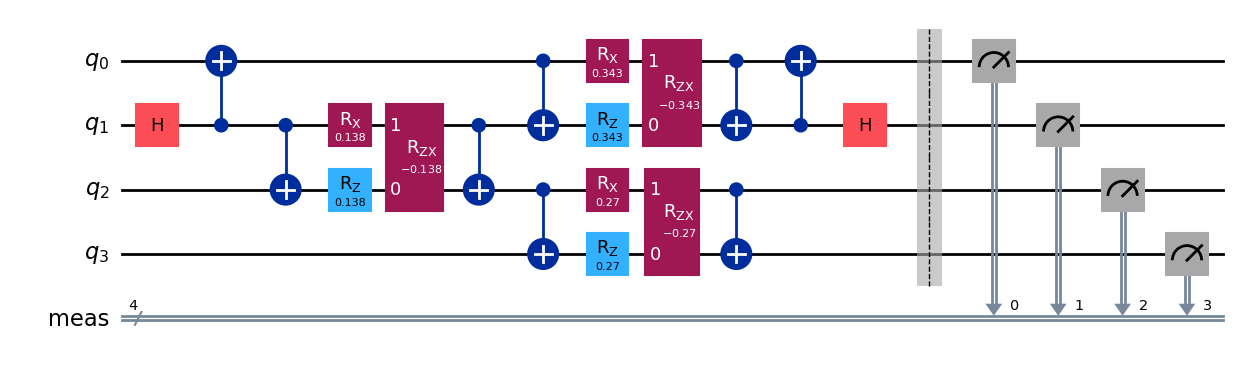

In [25]:
# Check a partial circuit
sample_id = 5
feature_id = 1

print("before transpile")
print(
    f"circuit depth: {circuits_phase0[f'sample{sample_id}'][f'f_{feature_id}'].depth()}"
)
print(
    f"count_ops: {circuits_phase0[f'sample{sample_id}'][f'f_{feature_id}'].count_ops()}"
)
circuits_phase0[f"sample{sample_id}"][f"f_{feature_id}"].draw(
    output="mpl", idle_wires=False
)

before transpile
circuit depth: 29
count_ops: OrderedDict([('sx', 24), ('rz', 19), ('cz', 9), ('measure', 4), ('barrier', 1)])


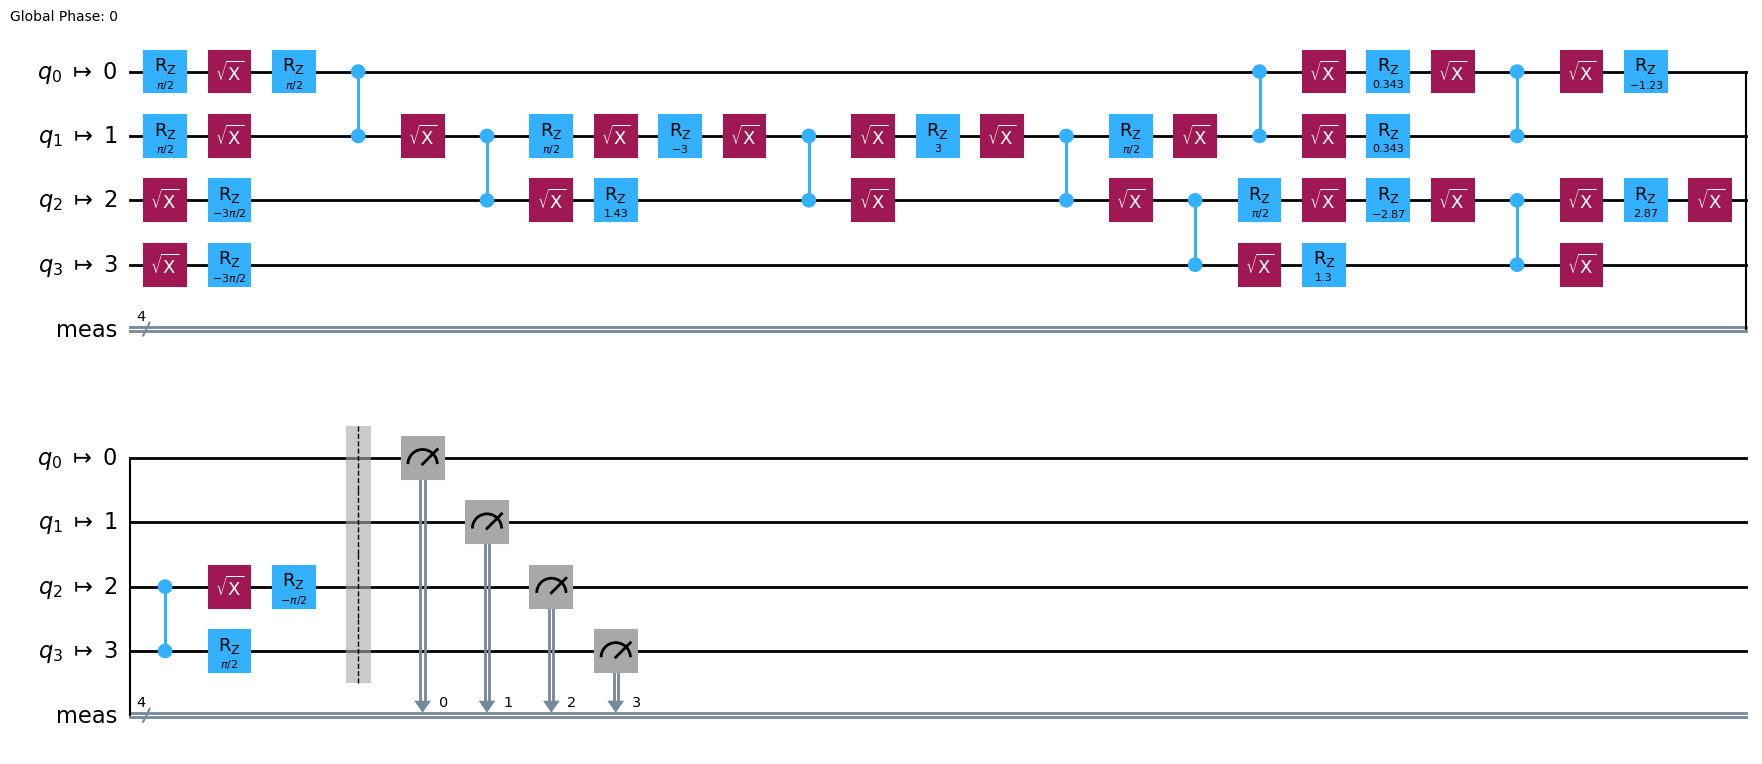

In [26]:
print("before transpile")
print(
    f"circuit depth: {exec_circuits_phase0[f'sample{sample_id}'][f'f_{feature_id}'].depth()}"
)
print(
    f"count_ops: {exec_circuits_phase0[f'sample{sample_id}'][f'f_{feature_id}'].count_ops()}"
)
exec_circuits_phase0[f"sample{sample_id}"][f"f_{feature_id}"].draw(
    output="mpl", idle_wires=False
)

In [27]:
# Run jobs in batch
job_ids = []
mit = mthree.M3Mitigation(backend_qpu)
with Batch(backend=backend_qpu) as batch:
    sampler = Sampler()
    mit.cals_from_system(runtime_mode=batch)
    # Turn on dynamical decoupling.
    sampler.options.dynamical_decoupling.enable = True

    for i in range(n_samples):
        print(f"Submitting circuits for sample {i}/{n_samples}")
        exec_circuits_per_sample = []
        exec_circuits_per_sample += [
            exec_circuits_phase0[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase1[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase2[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]
        exec_circuits_per_sample += [
            exec_circuits_phase3[f"sample{i}"][f"f_{k}"] for k in range(n_features)
        ]

        job = sampler.run(exec_circuits_per_sample)
        job_ids.append(job.job_id())

Submitting circuits for sample 0/20
Submitting circuits for sample 1/20
Submitting circuits for sample 2/20
Submitting circuits for sample 3/20
Submitting circuits for sample 4/20
Submitting circuits for sample 5/20
Submitting circuits for sample 6/20
Submitting circuits for sample 7/20
Submitting circuits for sample 8/20
Submitting circuits for sample 9/20
Submitting circuits for sample 10/20
Submitting circuits for sample 11/20
Submitting circuits for sample 12/20
Submitting circuits for sample 13/20
Submitting circuits for sample 14/20
Submitting circuits for sample 15/20
Submitting circuits for sample 16/20
Submitting circuits for sample 17/20
Submitting circuits for sample 18/20
Submitting circuits for sample 19/20


In [28]:
with open(f"{path}/first_try_job_ids.txt", "w") as f:
    for job_id in job_ids:
        f.write(f"{job_id}\n")

first_try_started_at = batch.details()["started_at"]

In [29]:
# Note: This line can be finished only after the calibration job (tagged with "M3 calibration") is finished.
mit.cals_to_file(f"{path}/calibrations_{first_try_started_at}.json")

with open(f"{path}/first_try_started_at.txt", "w") as f:
    f.write(first_try_started_at)

## Post process

In [64]:
# Load the params, job IDs and started_at time
# current_time = "2024-11-14T05:27:22.407Z"
with open(f"{path}/params.pkl", "rb") as f:
    params = pickle.load(f)
backend_qpu_name = params["backend_qpu_name"]

In [65]:
with open(f"{path}/first_try_job_ids.txt", "r") as f:
    first_try_job_ids = [job_id.strip() for job_id in f.readlines()]
with open(f"{path}/first_try_started_at.txt", "r") as f:
    first_try_started_at = f.read()

# Load calibration data
cals_file = f"{path}/calibrations_{first_try_started_at}.json"
mit = mthree.M3Mitigation(backend_qpu)
mit.cals_from_file(cals_file)

In [66]:
# Scan the status of the jobs
successful_job_ids_and_samples = {}
failed_job_ids_ids_and_samples = {}
successful_results = {}

for i in range(n_samples):
    print(f"Checking job {i}/{n_samples}")
    job_id = first_try_job_ids[i]
    job = service.job(job_id)

    if job.status() == "DONE":
        successful_job_ids_and_samples[f"sample{i}"] = job_id
        successful_results[f"sample{i}"] = job.result()
    elif job.status() == "ERROR":
        failed_job_ids_ids_and_samples[f"sample{i}"] = job_id

print()
print("successful samples and job ids")
for sample_id, job_id in successful_job_ids_and_samples.items():
    print(f"{sample_id}: {job_id}")
print()
print("failed samples and job ids")
for sample_id, job_id in failed_job_ids_ids_and_samples.items():
    print(f"{sample_id}: {job_id}")
print()
print(f"Success rate: { len(successful_job_ids_and_samples) / n_samples }")

with open(f"{path}/successful_job_ids_and_samples.json", "w") as f:
    json.dump(successful_job_ids_and_samples, f)
with open(f"{path}/failed_job_ids_ids_and_samples.json", "w") as f:
    json.dump(failed_job_ids_ids_and_samples, f)

Checking job 0/20
Checking job 1/20
Checking job 2/20
Checking job 3/20
Checking job 4/20
Checking job 5/20
Checking job 6/20
Checking job 7/20
Checking job 8/20
Checking job 9/20
Checking job 10/20
Checking job 11/20
Checking job 12/20
Checking job 13/20
Checking job 14/20
Checking job 15/20
Checking job 16/20
Checking job 17/20
Checking job 18/20
Checking job 19/20

successful samples and job ids
sample0: cx214httpsjg0086gkr0
sample1: cx214jabqkhg0083q6v0
sample2: cx214jtpjw300082xfk0
sample3: cx214kapjw300082xfkg
sample4: cx214kjbqkhg0083q6vg
sample5: cx214m2ztp30008ew8tg
sample6: cx214mjpjw300082xfm0
sample7: cx214n2bqkhg0083q6w0
sample8: cx214njrkac000800na0
sample9: cx214p2bqkhg0083q6wg
sample10: cx214papx23g008y9a8g
sample11: cx214q2ztp30008ew8vg
sample12: cx214qapjw300082xfn0
sample13: cx214qtrkac000800nag
sample14: cx214rbrkac000800nb0
sample15: cx214rvrkac000800nbg
sample16: cx214sbztp30008ew8w0
sample17: cx214skpx23g008y9a9g
sample18: cx214t3ztp30008ew8wg
sample19: cx214tktp

In [67]:
# Load parameters
with open(f"{path}/params.pkl", "rb") as f:
    params = pickle.load(f)

n_samples = params["n_samples"]
n_qubits = params["n_qubits"]
backend_qpu_name = params["backend_qpu_name"]
beta = params["beta"]
C = params["C"]
n_features = params["n_features"]
times = params["times"]
all_Js = params["Js"]
graphs = params["graphs"]
all_expected_values = params["expected_values"]

In [ ]:
# Note: this is only for the successful jobs

data_qpu_nmit = []
data_qpu_mit = []
probs_phase0_nmit = {}
probs_phase1_nmit = {}
probs_phase2_nmit = {}
probs_phase3_nmit = {}
probs_phase0_mit = {}
probs_phase1_mit = {}
probs_phase2_mit = {}
probs_phase3_mit = {}

# Note: sample_id is string, not integer
for sample_id, result in successful_results.items():
    print(f"Processing job {sample_id}")
    features_nmit = []
    features_mit = []
    probs_phase0_nmit[sample_id] = {}
    probs_phase1_nmit[sample_id] = {}
    probs_phase2_nmit[sample_id] = {}
    probs_phase3_nmit[sample_id] = {}
    probs_phase0_mit[sample_id] = {}
    probs_phase1_mit[sample_id] = {}
    probs_phase2_mit[sample_id] = {}
    probs_phase3_mit[sample_id] = {}

    for k in range(n_features):
        # Get results of each phase in a batch
        # phase_results = result[4 * k : 4 * k + 4]
        # probs = [
        #     get_prob0(phase_result, n_qubits, mit) for phase_result in phase_results
        # ]

        # Get results of each phase in a batch
        results_phase0 = result[:n_features]
        results_phase1 = result[n_features : 2 * n_features]
        results_phase2 = result[2 * n_features : 3 * n_features]
        results_phase3 = result[3 * n_features :]

        prob_phase0_nmit, prob_phase0_mit = get_prob0(results_phase0[k], n_qubits, mit)
        prob_phase1_nmit, prob_phase1_mit = get_prob0(results_phase1[k], n_qubits, mit)
        prob_phase2_nmit, prob_phase2_mit = get_prob0(results_phase2[k], n_qubits, mit)
        prob_phase3_nmit, prob_phase3_mit = get_prob0(results_phase3[k], n_qubits, mit)

        if prob_phase0_mit > 1:
            prob_phase0_mit = 1
        elif prob_phase0_mit < 0:
            prob_phase0_mit = 0
        if prob_phase1_mit > 1:
            prob_phase1_mit = 1
        elif prob_phase1_mit < 0:
            prob_phase1_mit = 0
        if prob_phase2_mit > 1:
            prob_phase2_mit = 1
        elif prob_phase2_mit < 0:
            prob_phase2_mit = 0
        if prob_phase3_mit > 1:
            prob_phase3_mit = 1
        elif prob_phase3_mit < 0:
            prob_phase3_mit = 0

        probs_phase0_nmit[sample_id][f"f_{k}"] = prob_phase0_nmit
        probs_phase1_nmit[sample_id][f"f_{k}"] = prob_phase1_nmit
        probs_phase2_nmit[sample_id][f"f_{k}"] = prob_phase2_nmit
        probs_phase3_nmit[sample_id][f"f_{k}"] = prob_phase3_nmit
        probs_phase0_mit[sample_id][f"f_{k}"] = prob_phase0_mit
        probs_phase1_mit[sample_id][f"f_{k}"] = prob_phase1_mit
        probs_phase2_mit[sample_id][f"f_{k}"] = prob_phase2_mit
        probs_phase3_mit[sample_id][f"f_{k}"] = prob_phase3_mit

        inner_product_nmit = np.exp(-1j * lambda_refs[sample_id] * times[k]) * (
            (prob_phase0_nmit - prob_phase1_nmit)
            + 1j * (prob_phase2_nmit - prob_phase3_nmit)
        )
        inner_product_mit = np.exp(-1j * lambda_refs[sample_id] * times[k]) * (
            (prob_phase0_mit - prob_phase1_mit)
            + 1j * (prob_phase2_mit - prob_phase3_mit)
        )
        features_nmit.append(inner_product_nmit.real)
        features_mit.append(inner_product_mit.real)
        if k != 0:
            features_nmit.append(inner_product_nmit.imag)
            features_mit.append(inner_product_mit.imag)

    # Because sample_id is string (e.g. "sample0"), convert it to integer.
    sample_id_int = int(sample_id.replace("sample", ""))
    data_qpu_nmit.append(
        [sample_id_int, *features_nmit, all_expected_values[sample_id_int]]
    )
    data_qpu_mit.append(
        [sample_id_int, *features_mit, all_expected_values[sample_id_int]]
    )

# Create column names for the DataFrame
columns = []
columns.append("sample_id")
for k in range(n_features):
    columns.append(f"f_{k} Re")
    if k != 0:
        columns.append(f"f_{k} Im")
columns.append("expected_value")

# Convert to a DataFrame
data_qpu_nmit_df = pd.DataFrame(data_qpu_mit, columns=columns)
data_qpu_mit_df = pd.DataFrame(data_qpu_nmit, columns=columns)
print("QPU no mitigation")
display(data_qpu_nmit_df)
print("QPU with mitigation")
display(data_qpu_mit_df)

# Save the qpu data
data_qpu_nmit_df.to_json(f"{path}/data_qpu_nmit_df.json")
data_qpu_mit_df.to_json(f"{path}/data_qpu_mit_df.json")

Processing job sample0
Processing job sample1
Processing job sample2
Processing job sample3
Processing job sample4
Processing job sample5
Processing job sample6
Processing job sample7
Processing job sample8
Processing job sample9
Processing job sample10
Processing job sample11
Processing job sample12
Processing job sample13
Processing job sample14
Processing job sample15
Processing job sample16
Processing job sample17
Processing job sample18
Processing job sample19
QPU no mitigation


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.996261,0.687966,-0.470497,0.215154,-0.572813,-0.056403,-0.301098,0.074233,0.095039,0.019342
1,1,0.997007,0.881860,0.170649,0.710702,0.255365,0.462841,0.302712,0.217188,0.247525,0.240820
2,2,1.000000,0.861515,-0.329456,0.721440,-0.518535,0.543902,-0.649919,0.298258,-0.740520,0.032718
3,3,0.997071,0.900382,0.094897,0.706845,0.156452,0.466294,0.146962,0.186351,0.093186,0.415421
4,4,0.997021,0.870839,0.301381,0.654631,0.651465,0.389062,0.834304,0.005836,0.917455,0.903064
5,5,0.999044,0.889180,-0.259878,0.786717,-0.430029,0.679027,-0.544559,0.466576,-0.636913,0.017484
6,6,0.996052,0.821568,0.127296,0.504114,0.114893,0.071276,0.021579,-0.335727,-0.135496,0.208174
7,7,0.997198,0.843728,-0.326688,0.600479,-0.508667,0.302846,-0.438472,0.082780,-0.265122,0.106176
8,8,0.995553,0.878506,-0.107898,0.683480,-0.103860,0.409976,-0.076990,0.117783,-0.024435,0.162962
9,9,0.995020,0.823204,0.145734,0.470346,0.215794,0.055863,0.059436,-0.260693,-0.234790,0.337633


QPU with mitigation


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.977539,0.675373,-0.461717,0.211079,-0.562331,-0.055408,-0.295551,0.072809,0.093250,0.019342
1,1,0.978271,0.865917,0.167422,0.697617,0.250633,0.454345,0.297072,0.213217,0.242870,0.240820
2,2,0.983398,0.845622,-0.323378,0.708255,-0.508959,0.533840,-0.637929,0.292712,-0.726661,0.032718
3,3,0.978271,0.883883,0.093122,0.693708,0.153338,0.457458,0.144066,0.182754,0.091289,0.415421
4,4,0.978271,0.854837,0.295839,0.642567,0.639676,0.381817,0.818937,0.005737,0.900656,0.903064
5,5,0.981689,0.872747,-0.255196,0.772212,-0.422205,0.666526,-0.534592,0.458052,-0.625221,0.017484
6,6,0.977295,0.806574,0.124809,0.494932,0.112622,0.069907,0.021231,-0.329318,-0.132949,0.208174
7,7,0.978516,0.828392,-0.320463,0.589538,-0.499218,0.297133,-0.430387,0.081273,-0.260396,0.106176
8,8,0.976807,0.862227,-0.105732,0.670833,-0.101773,0.402173,-0.075471,0.115751,-0.023993,0.162962
9,9,0.976318,0.807961,0.143060,0.461556,0.211736,0.054684,0.058291,-0.256075,-0.230691,0.337633


## Plot data

In [74]:
dummy_successful_results = {}
for i in range(n_samples):
    dummy_successful_results[f"sample{i}"] = None

successful_results = dummy_successful_results

In [75]:
probs_phase0_exact_extracted = extract_probs(
    probs_phase0_exact, successful_results.keys()
)
probs_phase1_exact_extracted = extract_probs(
    probs_phase1_exact, successful_results.keys()
)
probs_phase2_exact_extracted = extract_probs(
    probs_phase2_exact, successful_results.keys()
)
probs_phase3_exact_extracted = extract_probs(
    probs_phase3_exact, successful_results.keys()
)

probs_phase0_sim_extracted = extract_probs(probs_phase0_sim, successful_results.keys())
probs_phase1_sim_extracted = extract_probs(probs_phase1_sim, successful_results.keys())
probs_phase2_sim_extracted = extract_probs(probs_phase2_sim, successful_results.keys())
probs_phase3_sim_extracted = extract_probs(probs_phase3_sim, successful_results.keys())

probs_phase0_sim_noisy_extracted = extract_probs(
    probs_phase0_sim_noisy, successful_results.keys()
)
probs_phase1_sim_noisy_extracted = extract_probs(
    probs_phase1_sim_noisy, successful_results.keys()
)
probs_phase2_sim_noisy_extracted = extract_probs(
    probs_phase2_sim_noisy, successful_results.keys()
)
probs_phase3_sim_noisy_extracted = extract_probs(
    probs_phase3_sim_noisy, successful_results.keys()
)

probs_phase0_nmit_extracted = extract_probs(
    probs_phase0_nmit, successful_results.keys()
)
probs_phase1_nmit_extracted = extract_probs(
    probs_phase1_nmit, successful_results.keys()
)
probs_phase2_nmit_extracted = extract_probs(
    probs_phase2_nmit, successful_results.keys()
)
probs_phase3_nmit_extracted = extract_probs(
    probs_phase3_nmit, successful_results.keys()
)

probs_phase0_mit_extracted = extract_probs(probs_phase0_mit, successful_results.keys())
probs_phase1_mit_extracted = extract_probs(probs_phase1_mit, successful_results.keys())
probs_phase2_mit_extracted = extract_probs(probs_phase2_mit, successful_results.keys())
probs_phase3_mit_extracted = extract_probs(probs_phase3_mit, successful_results.keys())

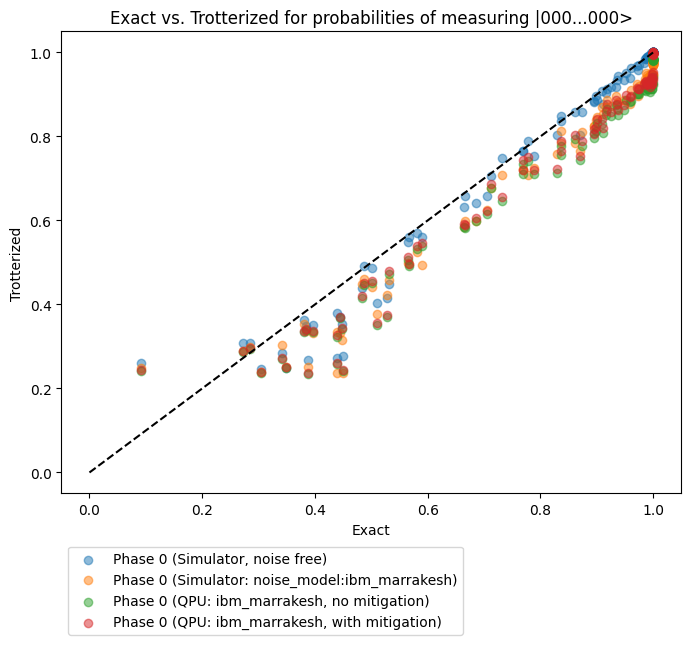

In [76]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_sim_extracted,
    label=f"Phase 0 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_sim_noisy_extracted,
    label=f"Phase 0 (Simulator: noise_model:{backend_qpu.name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_nmit_extracted,
    label=f"Phase 0 (QPU: {backend_qpu.name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_mit_extracted,
    label=f"Phase 0 (QPU: {backend_qpu.name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

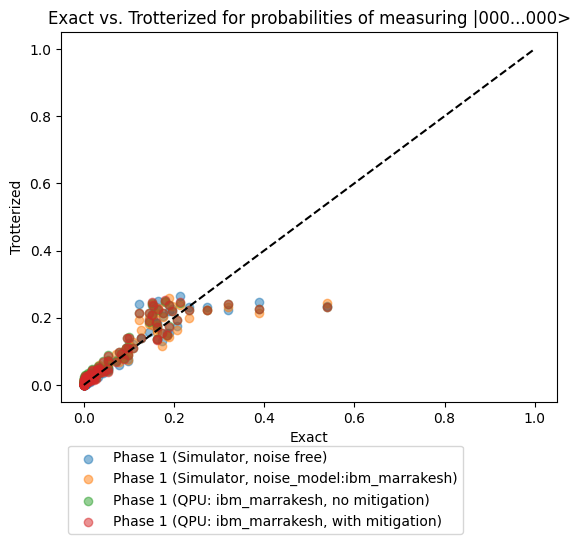

In [77]:
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_sim_extracted,
    label=f"Phase 1 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_sim_noisy_extracted,
    label=f"Phase 1 (Simulator, noise_model:{backend_qpu.name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_nmit_extracted,
    label=f"Phase 1 (QPU: {backend_qpu.name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_mit_extracted,
    label=f"Phase 1 (QPU: {backend_qpu.name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

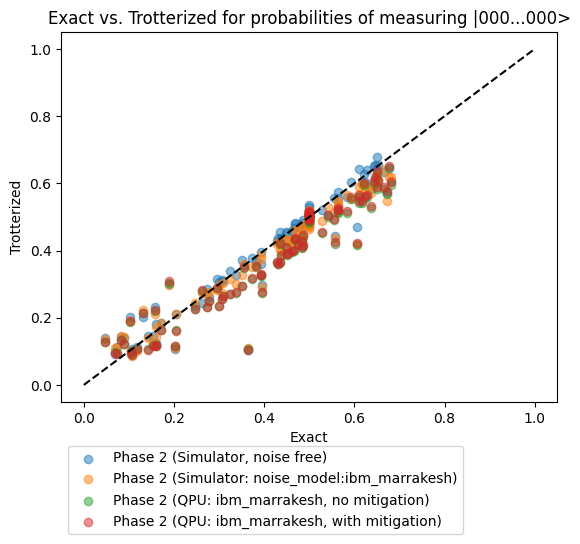

In [78]:
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_sim_extracted,
    label=f"Phase 2 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_sim_noisy_extracted,
    label=f"Phase 2 (Simulator: noise_model:{backend_qpu.name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_nmit_extracted,
    label=f"Phase 2 (QPU: {backend_qpu.name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_mit_extracted,
    label=f"Phase 2 (QPU: {backend_qpu.name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")

plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

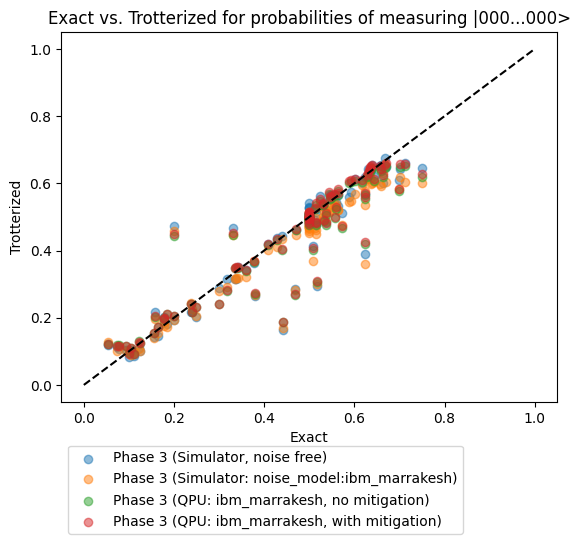

In [79]:
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_sim_extracted,
    label=f"Phase 3 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_sim_noisy_extracted,
    label=f"Phase 3 (Simulator: noise_model:{backend_qpu.name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_nmit_extracted,
    label=f"Phase 3 (QPU: {backend_qpu.name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_mit_extracted,
    label=f"Phase 3 (QPU: {backend_qpu.name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()